<a href="https://colab.research.google.com/github/OmerElshrief/ModulationRecognition/blob/master/ColabNotebok/ModulationRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** Basic Model **

In [0]:
h[1]

[1, 2, 3, 4]

In [0]:
import _pickle as pkl
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# ** Load data **

### Ordinary

In [0]:
#xd = pkl.load(open('drive/My Drive/pattern projects data/RML2016.10b.dat', 'rb'), encoding = 'latin1')
xd = pkl.load(open('drive/My Drive/RML2016.10b.dat', 'rb'), encoding = 'latin1')

snrs, sigs = map(lambda j: sorted(list(set(map(lambda x: x[j], xd.keys())))), [1, 0])

data = []
details = []

for sig in sigs:
  for snr in snrs:
    data.append(xd[(sig, snr)])
    for i in range(xd[sig, snr].shape[0]):
      details.append((sig, snr))

FileNotFoundError: ignored

In [0]:
data = np.vstack(data)
print(data.shape)
details = np.array(details)
#snr = details[:, 1]
#labels = details[:, 0]

(1200000, 2, 128)


In [0]:
le = LabelEncoder()
encoded = le.fit_transform(details[:, 0])
#enc = OneHotEncoder()
#encoded = enc.fit_transform(encoded.reshape(-1, 1))
print(encoded.shape)

(1200000,)


 ### Load - Splitting and Shuffling the Data based on SNR

In [0]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd =  pkl.load(open("drive/My Drive/RML2016.10b.dat",'rb'),encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [0]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    
    lyy = list(yy)
    yy1 = np.zeros([len(lyy), 10])
    yy1[np.arange(len(lyy)),lyy] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

#### splitting training Data into Train and Validation

In [0]:
## Keras Model 
X = np.reshape(X_train, (-1, 2, 128, 1))

train_X, val_X, train_y, val_y = train_test_split(X, Y_train, test_size = 0.3, random_state = 1)


In [0]:
val_X.shape

(252000, 2, 128, 1)

In [0]:
X_test.shape

(360000, 2, 128)

# ** Pytorch Model **

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return x

In [0]:
class Model(nn.Module):
  
  def __init__(self, residual = False, LSTM = False):
    super(Model, self).__init__()
    self.residual = residual
    self.lstm = LSTM
    
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 128, kernel_size = (1, 3), stride = 1, padding = (0, 1))
    self.conv2 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (2, 3), stride = 1, padding = (0, 1))
    self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = (1, 3), stride = 1, padding = (0, 1))
    self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (1, 3), stride = 1, padding = (0, 1))
    
    ## Potential LSTM part here
    
    ##self.lstm_part = nn.Sequential(nn.Conv2d(in_channels = 80, out_channels = 1, kernel_size = (1, 1)),
    ##                               flatten(),
    ##                               nn.ModuleList([nn.LSTM(128, 128) for i in range(50)])
    ##                               )
    
    self.fc1 = nn.Linear(64*128, 128)
    self.fc2 = nn.Linear(128, 10)
  
  
  def forward(self, x):
    
    op = x
    op = F.relu(self.conv1(op))
    op = F.relu(self.conv2(op))
    op = F.relu(self.conv3(op))
    op = F.relu(self.conv4(op))
    
    if self.lstm:
      ## Add LSTM
      op = op.view(-1)
    else:
      op = op.view(op.shape[0], -1)
      
    op = F.relu(self.fc1(op))
    op = self.fc2(op)
    
    return op

In [0]:
class CNNModel(nn.Module):
  
  def __init__(self, residual = False, LSTM = False):
    super(CNNModel, self).__init__()
    
    self.residual = residual
    self.lstm = LSTM
    
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (1, 3), stride = 1, padding = (0, 1))
    self.dropout1 = nn.Dropout(0.5)
    self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 16, kernel_size = (2, 3), stride = 1, padding = (1, 2))
    self.dropout2 = nn.Dropout(0.5)
    
    self.fc1 = nn.Linear(3*130*16, 128)
    self.fc2 = nn.Linear(128, 10)
  
  
  def forward(self, x):
    
    op = x
    op = F.relu(self.conv1(op))
    op = F.relu(self.conv2(op))
    
    if self.lstm:
      ## Add LSTM
      op = op.view(-1)
    else:
      op = op.view(op.shape[0], -1)
      
    op = F.relu(self.fc1(op))
    op = self.fc2(op)
    
    return op

** Training **

In [0]:
## Model 1
X = np.reshape(data, (1200000, 1, 2, 128))

In [0]:
## Model 2
X = np.reshape(data, (1200000, 128, 1, 2))

In [0]:
print(X.shape)

(1200000, 1, 2, 128)


In [0]:
BATCH_SIZE, NUM_EPOCHS, lr = 1024, 1, 0.00005
num_batches = int(X_train.shape[0] / BATCH_SIZE + 0.5)

device = torch.device("cuda:0")

model = CNNModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [0]:
statistics = []

In [0]:
for i in range(NUM_EPOCHS):
  for j in range(num_batches):
    start = j * BATCH_SIZE
    end = (j+1) * BATCH_SIZE
    if end > X_train.shape[0]:
       end = X_train.shape[0]
    
    batch = torch.from_numpy(X_train[start:end])
    y_true = torch.tensor(y_train[start:end], dtype=torch.long)
    
    y_pred = model.forward(batch)
    ##print(y_pred)
    
    loss = criterion(y_pred, y_true)
    
    print(j, loss.item())
    statistics.append(loss.item())
    #print('accuracy =', np.count_nonzero(torch.argmax(y_pred, dim=1) ==  y_true))

    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()


** Save Model **

In [0]:
path = 'model_params'
torch.save(model.state_dict(), path)

** Load Model **

In [0]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(path))
model.eval()

# ** Keras Model **

In [0]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, Dropout

#from keras.layers import Embedding, Conv1D, Convolution1D, MaxPooling1D
#from keras.layers import Concatenate, SpatialDropout1D, Reshape

from keras.regularizers import l2

from keras.optimizers import Adam

from keras.callbacks import TensorBoard
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.utils.vis_utils import plot_model

from keras.layers import LSTM, TimeDistributed
from keras.models import model_from_json

Using TensorFlow backend.


In [0]:
basic_model = Sequential()

basic_model.add(Conv2D(64, kernel_size=(1, 3), padding = 'same', activation= 'relu', input_shape=(2, 128, 1)))
basic_model.add(Dropout(0.5))
basic_model.add(Conv2D(16, kernel_size=(2, 3), padding = 'same', activation= 'relu'))
#basic_model.add(Dropout(0.5))
basic_model.add(Flatten())
basic_model.add(Dense(128, activation='relu'))
basic_model.add(Dropout(0.5))
basic_model.add(Dense(10, activation='softmax'))

basic_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics = ['accuracy'])
basic_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 2, 128, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 128, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 128, 16)        6160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               524416    
_________________________________________________________________
dropout_2 (Dropout)  

** Deeper Model **

In [0]:
deep_model = Sequential()

deep_model.add(Conv2D(256, kernel_size=(1, 3), padding = 'same', activation= 'relu', input_shape=(2, 128, 1)))
deep_model.add(Dropout(0.6))
deep_model.add(Conv2D(256, kernel_size=(2, 3), padding = 'same', activation= 'relu'))
deep_model.add(Dropout(0.6))
deep_model.add(Conv2D(80, kernel_size=(1, 3), padding = 'same', activation= 'relu'))
deep_model.add(Dropout(0.6))
deep_model.add(Conv2D(80, kernel_size=(1, 3), padding = 'same', activation= 'relu'))
deep_model.add(Dropout(0.6))
deep_model.add(Flatten())
deep_model.add(Dense(128, activation='relu'))
deep_model.add(Dropout(0.5))
deep_model.add(Dense(10, activation='softmax'))

deep_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics = ['accuracy'])
deep_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 2, 128, 256)       1024      
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 128, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 128, 256)       393472    
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 128, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 128, 80)        61520     
_________________________________________________________________
dropout_8 (Dropout)          (None, 2, 128, 80)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 128, 80)        19280     
__________

** CLDNN Model **

In [0]:
lstm_model = Sequential()

lstm_model.add(Conv2D(128, kernel_size=(1, 3), padding = 'same', activation= 'relu', input_shape=(2, 128, 1)))
lstm_model.add(Dropout(0.6))
lstm_model.add(Conv2D(64, kernel_size=(2, 3), padding = 'same', activation= 'relu'))
lstm_model.add(Dropout(0.6))
lstm_model.add(Conv2D(32, kernel_size=(1, 3), padding = 'same', activation= 'relu'))
lstm_model.add(Dropout(0.6))
lstm_model.add(Conv2D(16, kernel_size=(2, 3), padding = 'same', activation= 'relu'))
lstm_model.add(Dropout(0.6))
lstm_model.add(TimeDistributed(Flatten()))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dropout(0.6))
lstm_model.add(Dense(10, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics = ['accuracy'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 2, 128, 128)       512       
_________________________________________________________________
dropout_33 (Dropout)         (None, 2, 128, 128)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 2, 128, 64)        49216     
_________________________________________________________________
dropout_34 (Dropout)         (None, 2, 128, 64)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 2, 128, 32)        6176      
_________________________________________________________________
dropout_35 (Dropout)         (None, 2, 128, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 2, 128, 16)        3088      
__________

In [0]:
import keras.backend as K

print(K.eval(lstm_model.optimizer.lr))

0.001


### Another LTSM-ResNet model

In [0]:
from keras.engine.topology import Layer
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Add
# Define the residual block as a new layer
class Residual(Layer):
    def __init__(self, channels_in,kernel,**kwargs):
        super(Residual, self).__init__(**kwargs)
        self.channels_in = channels_in
        self.kernel = kernel

    def call(self, x):
        # the residual block using Keras functional API
        first_layer =   Activation("linear", trainable=False)(x)
        x =             Conv2D( self.channels_in,
                                self.kernel,
                                padding="same")(first_layer)
        x =             Activation("relu")(x)
        x =             Conv2D( self.channels_in,
                                self.kernel,
                                padding="same")(x)
        residual =      Add()([x, first_layer])
        x =             Activation("relu")(residual)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape
 

lstmResnet_model = Sequential()

lstmResnet_model.add(Conv2D(128, kernel_size=(1, 3), padding = 'same', activation= 'relu', input_shape=(2, 128, 1)))
lstmResnet_model.add(Dropout(0.6))
#.add(Residual(128,(1,3)))
lstmResnet_model.add(Conv2D(64, kernel_size=(2, 3), padding = 'same', activation= 'relu'))
lstmResnet_model.add(Dropout(0.6))

lstmResnet_model.add(Residual(64,(2,3)))

lstmResnet_model.add(Conv2D(32, kernel_size=(1, 3), padding = 'same', activation= 'relu'))
lstmResnet_model.add(Dropout(0.6))
lstmResnet_model.add(Residual(32,(1,3)))
lstmResnet_model.add(Residual(32,(2,3)))
lstmResnet_model.add(Conv2D(16, kernel_size=(1, 3), padding = 'same', activation= 'relu'))
lstmResnet_model.add(Dropout(0.6))

lstmResnet_model.add(TimeDistributed(Flatten()))
lstmResnet_model.add(LSTM(64))

lstmResnet_model.add(Dense(128, activation='relu'))
lstmResnet_model.add(Dropout(0.6))
lstmResnet_model.add(Dense(10, activation='softmax'))

lstmResnet_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics = ['accuracy'])
lstmResnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 2, 128, 128)       512       
_________________________________________________________________
dropout_11 (Dropout)         (None, 2, 128, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 2, 128, 64)        49216     
_________________________________________________________________
dropout_12 (Dropout)         (None, 2, 128, 64)        0         
_________________________________________________________________
residual_5 (Residual)        (None, 2, 128, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 2, 128, 32)        6176      
_________________________________________________________________
dropout_13 (Dropout)         (None, 2, 128, 32)        0         
__________

# ** Generalized Model **

In [0]:
class ModelBuilder:
  
  def__init__(self, filter_sizes, filter_shapes, dropout_probs,
              rnn = False, rnn_cells = 50,
              loss = 'categorical_crossentropy', optimizer = 'Adam'):
    self.conv_layers_cnt = filter_sizes.size()
    self.filter_sizes = filter_sizes
    self.filter_shapes = filter_shapes
    self.rnn = rnn
    self.rnn_cells = rnn_cells
    self.model = model
    
    
  def build_model():
    self.model = Sequential()
    self.model.add(Conv2D(self.filter_sizes[0], kernel_size=self.filter_shapes[0], padding = 'same', activation= 'relu', input_shape=(2, 128, 1)))
    self.model.add(Dropout(self.dropout_probs[0]))
    
    for f in range(1, self.conv_layers_cnt):
      self.model.add(Conv2D(self.filter_sizes[f], kernel_size=self.filter_sizes[f], padding = 'same', activation= 'relu'))
      self.model.add(Dropout(self.dropout_probs[f]))
      
    if self.lstm:
      self.model.add(TimeDistributed(Flatten))
      se;f.model.add(GRU(self.rnn_cells))
      
    else:
      self.model.add(Flatten)
      
    self.model.add(Dense(128, activation='relu'))
    self.model.add(Dropout(0.5))
    self.model.add(Dense(10, activation='softmax'))  
    
    self.model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics = ['accuracy'])
    self.model.summary()
    return self.model

** Tuning details **

In [0]:
basic_model_params{
    'filter_sizes': [64, 16],
    'filter_shapes': [(1, 3), (2, 3)],
    'dropout_probs': [0.6, 0.6],
    'rnn' = False,
    'logger': 'basicCNN'
}

deep_model_params{
    'filter_sizes': [128, 64, 32, 16],
    'filter_shapes': [(1, 3), (2, 3), (1, 3), (1, 3)],
    'dropout_probs': [0.6, 0.6, 0.6, 0.6],
    'rnn' = False,
    'logger': 'deepCNN'
}

lstm_model_params{
    'filter_sizes': [128, 64, 32, 16],
    'filter_shapes': [(1, 3), (2, 3), (1, 3), (1, 3)],
    'dropout_probs': [0.6, 0.6, 0.6, 0.6],
    'rnn' = True, 
    'logger': 'CLDNN'
}

# ** Save a model **

In [0]:
import os
path = 'drive/My Drive/models/keras/CLDNN'
def save_model(lstm_model, path, arch = True, weights = False):
  # serialize model to JSON
  model_json = model.to_json()
  with open(os.path.join(path, 'arch.json'), "w") as json_file:
    json_file.write(model_json)
    # serialize weights to HDF5
lstm_model.save_weights(os.path.join(path, 'weights.h5'))
print("model Weights are saved")

model Weights are saved


# ** Training**

### Preparing Training Data

In [0]:
## Keras Model 
X = np.reshape(data, (1200000, 2, 128, 1))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, encoded, test_size = 0.3, random_state = 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(840000, 2, 128, 1) (840000,)
(360000, 2, 128, 1) (360000,)


In [0]:
enc = OneHotEncoder()
k_train = enc.fit_transform(y_train.reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
train_X, val_X, train_y, val_y = train_test_split(X_train, k_train, test_size = 0.3, random_state = 1)

In [0]:
print(y_train[1])

2


### ** Load model from drive **

In [0]:
path = "drive/My Drive/models/keras/CLDNN-ResNet/weights.h5"
# load weights into new model
lstmResnet_model.load_weights(path)
print("Loaded model from disk")
lstmResnet_model.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 2, 128, 128)       512       
_________________________________________________________________
dropout_17 (Dropout)         (None, 2, 128, 128)       0         
_________________________________________________________________
residual_7 (Residual)        (None, 2, 128, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 2, 128, 64)        49216     
_________________________________________________________________
dropout_18 (Dropout)         (None, 2, 128, 64)        0         
_________________________________________________________________
residual_8 (Residual)        (None, 2, 128, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 2, 128, 32)      

### Load a full Model

In [0]:
# load json and create model

path = 'drive/My Drive/models/keras/CLDNN-'
json_file = open((path+'/arch.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
lstm_model = model_from_json(loaded_model_json)
# load weights into new model
lstm_model.load_weights(path + '/weights.h5')
print("Loaded model from disk")
lstm_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics = ['accuracy'])
lstm_model.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 2, 128, 128)       512       
_________________________________________________________________
dropout_36 (Dropout)         (None, 2, 128, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 2, 128, 64)        49216     
_________________________________________________________________
dropout_37 (Dropout)         (None, 2, 128, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 2, 128, 32)        6176      
_________________________________________________________________
dropout_38 (Dropout)         (None, 2, 128, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 2, 128, 16)      

## Training LSTM Model

In [0]:
path = "drive/My Drive/models/keras/lstm_weights1new.h5"
cp_callback = ModelCheckpoint(path ,
                              monitor = 'val_acc',
                              save_best_only = True,
                              save_weights_only=True,
                              mode = 'max',
                              verbose=1)

##early_stop_callback = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=2, verbose=0, mode='max')


In [0]:
his = []

In [0]:
history = lstm_model.fit(x=train_X, y=train_y,
          batch_size= 1024, epochs= 50,
          verbose=2,
          callbacks = [cp_callback],
          validation_data=(val_X, val_y)
          )

his.append(history)

Train on 588000 samples, validate on 252000 samples
Epoch 1/50
 - 130s - loss: 1.0930 - acc: 0.5459 - val_loss: 1.0374 - val_acc: 0.5671

Epoch 00001: val_acc did not improve from 0.56957
Epoch 2/50
 - 130s - loss: 1.0914 - acc: 0.5458 - val_loss: 1.0514 - val_acc: 0.5648

Epoch 00002: val_acc did not improve from 0.56957
Epoch 3/50
 - 130s - loss: 1.0915 - acc: 0.5465 - val_loss: 1.0445 - val_acc: 0.5601

Epoch 00003: val_acc did not improve from 0.56957
Epoch 4/50
 - 130s - loss: 1.0900 - acc: 0.5466 - val_loss: 1.0475 - val_acc: 0.5592

Epoch 00004: val_acc did not improve from 0.56957
Epoch 5/50
 - 130s - loss: 1.0891 - acc: 0.5477 - val_loss: 1.0381 - val_acc: 0.5685

Epoch 00005: val_acc did not improve from 0.56957
Epoch 6/50
 - 130s - loss: 1.0885 - acc: 0.5470 - val_loss: 1.0554 - val_acc: 0.5572

Epoch 00006: val_acc did not improve from 0.56957
Epoch 7/50
 - 130s - loss: 1.0871 - acc: 0.5481 - val_loss: 1.0471 - val_acc: 0.5669

Epoch 00007: val_acc did not improve from 0.56

### Training Performance

In [0]:
no_epochs = [x for x in range(0,200)]

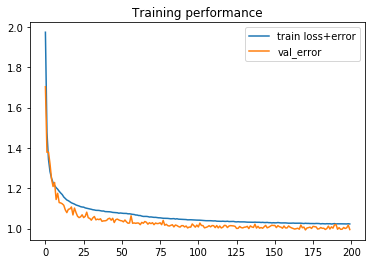

In [0]:
history = his[0]
history2 = his[1]
plt.figure()
plt.title('Training performance')
plt.plot(no_epochs, history.history['loss']+history2.history['loss'], label='train loss+error')
plt.plot(no_epochs, history.history['val_loss']+history2.history['val_loss'], label='val_error')
plt.legend()

### Teting the Model

#### Overall

In [0]:
X_test=X_test.reshape(-1,2,128,1)
score = lstm_model.evaluate(X_test, Y_test,  verbose=0, batch_size=1024)
print('Total overall score => Loss: {:.4f}   Over-All Accuracy: {:.0f}%'.format(score[0],100*score[1]))

Total overall score => Loss: 0.9935   Over-All Accuracy: 59%


### SNR Based

SNR: -20 - Accuracy: 11%   no. of test Signals: 18114 
SNR: -18 - Accuracy: 11%   no. of test Signals: 17921 
SNR: -16 - Accuracy: 11%   no. of test Signals: 17933 
SNR: -14 - Accuracy: 13%   no. of test Signals: 17911 
SNR: -12 - Accuracy: 17%   no. of test Signals: 18065 
SNR: -10 - Accuracy: 29%   no. of test Signals: 18003 
SNR: -8 - Accuracy: 39%   no. of test Signals: 18086 
SNR: -6 - Accuracy: 47%   no. of test Signals: 17878 
SNR: -4 - Accuracy: 63%   no. of test Signals: 18041 
SNR: -2 - Accuracy: 78%   no. of test Signals: 17895 
SNR: 0 - Accuracy: 84%   no. of test Signals: 17964 
SNR: 2 - Accuracy: 86%   no. of test Signals: 18078 
SNR: 4 - Accuracy: 86%   no. of test Signals: 18154 
SNR: 6 - Accuracy: 86%   no. of test Signals: 17837 
SNR: 8 - Accuracy: 86%   no. of test Signals: 18010 
SNR: 10 - Accuracy: 86%   no. of test Signals: 18051 
SNR: 12 - Accuracy: 87%   no. of test Signals: 17988 
SNR: 14 - Accuracy: 86%   no. of test Signals: 18049 
SNR: 16 - Accuracy: 86%   n

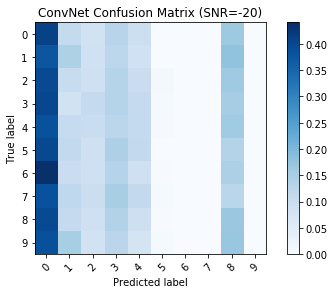

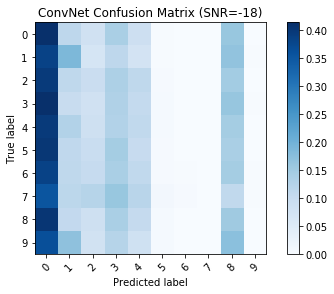

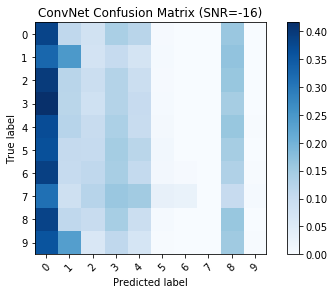

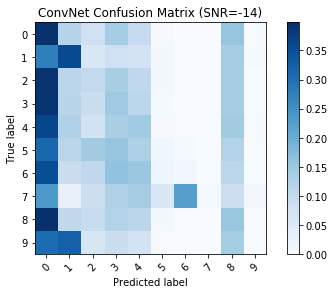

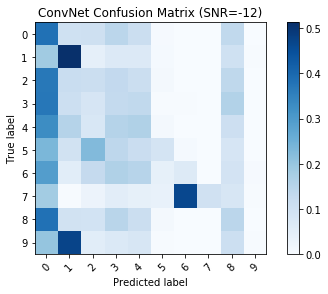

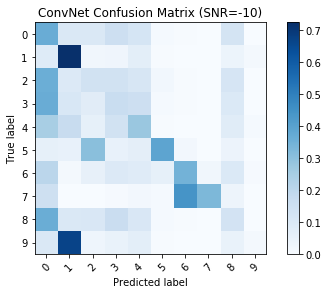

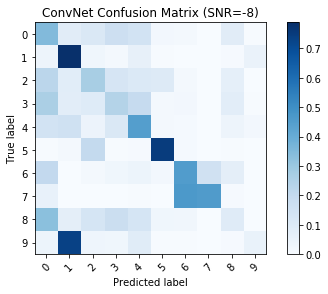

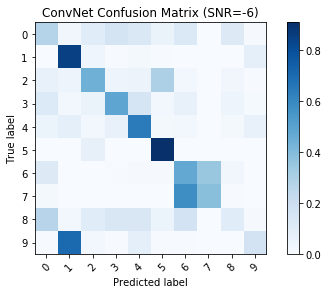

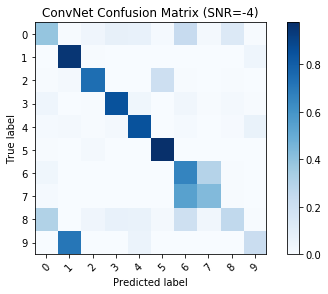

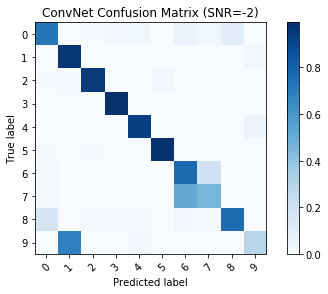

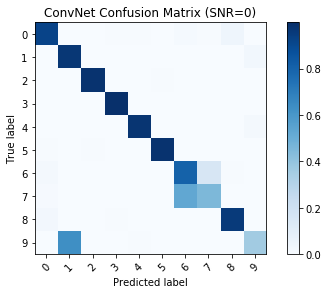

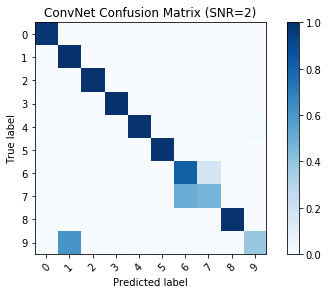

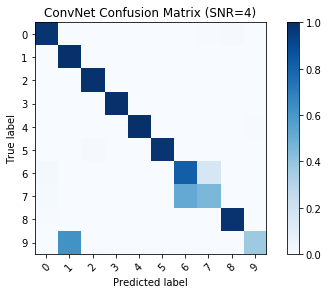

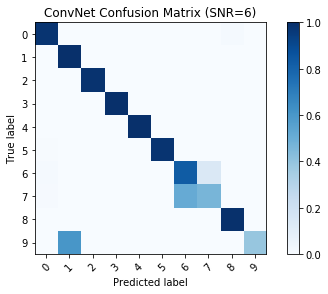

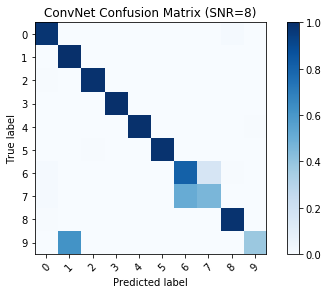

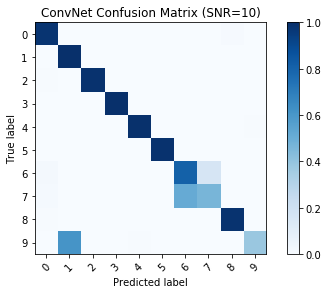

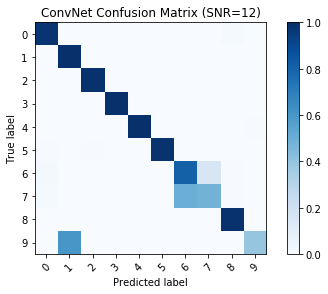

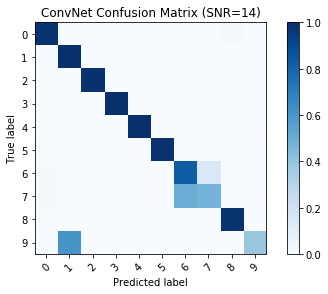

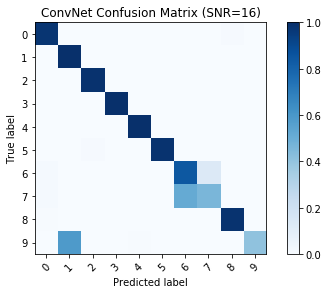

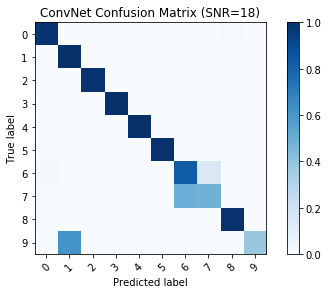

In [0]:
# Plot confusion matrix
acc = {}
classes = [0,1,2,3,4,5,6,7,8,9]
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    
    test_Y_i= np.array([np.argmax(x) for x in test_Y_i])
    #print(test_Y_i)
   
    # estimate classes
    test_X_i = (test_X_i).reshape(test_X_i.shape[0] , 2,128,1)
    test_Y_i_hat = lstm_model.predict(test_X_i)
    
    
    #print(test_Y_i_hat)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = test_Y_i[i]
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("SNR: {} - Accuracy: {:.0f}%   no. of test Signals: {} ".format(snr ,100* cor / (cor+ncor),test_X_i.shape[0]))
    acc[snr] = 1.0*cor/(cor+ncor)

In [0]:
from matplotlib import pyplot as plt
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## ** Deeep Model**

### Load w pre trained Model

In [0]:
path = "drive/My Drive/models/keras/deep_weights1.h5"
# load weights into new model
deep_model.load_weights(path)
print("Loaded model from disk")
deep_model.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 2, 128, 256)       1024      
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 128, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 128, 256)       393472    
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 128, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 128, 80)        61520     
_________________________________________________________________
dropout_8 (Dropout)          (None, 2, 128, 80)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 128, 80)      

In [0]:
path = "drive/My Drive/models/keras/deep_weights1.h5"
cp_callback = ModelCheckpoint(path ,
                              monitor = 'val_acc',
                              save_best_only = True,
                              save_weights_only=True,
                              mode = 'max',
                              verbose=1)

##early_stop_callback = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=2, verbose=0, mode='max')


In [0]:
his = []

In [0]:
history = deep_model.fit(x=train_X, y=train_y,
          batch_size= 1024, epochs= 50,
          verbose=2,
          callbacks = [cp_callback],
          validation_data=(val_X, val_y)
          )

his.append(history)

Instructions for updating:
Use tf.cast instead.
Train on 588000 samples, validate on 252000 samples
Epoch 1/50
 - 229s - loss: 1.9676 - acc: 0.2258 - val_loss: 1.9142 - val_acc: 0.2469

Epoch 00001: val_acc improved from -inf to 0.24685, saving model to drive/My Drive/models/keras/deep_weights1.h5
Epoch 2/50
 - 222s - loss: 1.6697 - acc: 0.3379 - val_loss: 1.4181 - val_acc: 0.4136

Epoch 00002: val_acc improved from 0.24685 to 0.41357, saving model to drive/My Drive/models/keras/deep_weights1.h5
Epoch 3/50
 - 222s - loss: 1.4645 - acc: 0.4019 - val_loss: 1.2761 - val_acc: 0.4610

Epoch 00003: val_acc improved from 0.41357 to 0.46104, saving model to drive/My Drive/models/keras/deep_weights1.h5
Epoch 4/50
 - 222s - loss: 1.4325 - acc: 0.4140 - val_loss: 1.2384 - val_acc: 0.4841

Epoch 00004: val_acc improved from 0.46104 to 0.48413, saving model to drive/My Drive/models/keras/deep_weights1.h5
Epoch 5/50
 - 222s - loss: 1.3803 - acc: 0.4331 - val_loss: 1.2259 - val_acc: 0.4932

Epoch 000

### Testing deep Model

In [0]:
X_test=X_test.reshape(-1,2,128,1)
score = deep_model.evaluate(X_test, Y_test,  verbose=0, batch_size=1024)
print('Over all model score=>  Loss: {:.4f}  Accuracy: {:.4f} %'.format(score[0],100*score[1]))

Over all model score=>  Loss: 1.0900  Accuracy: 0.5488


SNR: -20 - Accuracy: 10.539%   no. of test Signals: 18114 
SNR: -18 - Accuracy: 10.574%   no. of test Signals: 17921 
SNR: -16 - Accuracy: 11.298%   no. of test Signals: 17933 
SNR: -14 - Accuracy: 13.366%   no. of test Signals: 17911 
SNR: -12 - Accuracy: 16.003%   no. of test Signals: 18065 
SNR: -10 - Accuracy: 26.140%   no. of test Signals: 18003 
SNR: -8 - Accuracy: 40.186%   no. of test Signals: 18086 
SNR: -6 - Accuracy: 51.046%   no. of test Signals: 17878 
SNR: -4 - Accuracy: 60.922%   no. of test Signals: 18041 
SNR: -2 - Accuracy: 72.031%   no. of test Signals: 17895 
SNR: 0 - Accuracy: 78.000%   no. of test Signals: 17964 
SNR: 2 - Accuracy: 80.872%   no. of test Signals: 18078 
SNR: 4 - Accuracy: 81.156%   no. of test Signals: 18154 
SNR: 6 - Accuracy: 81.499%   no. of test Signals: 17837 
SNR: 8 - Accuracy: 81.888%   no. of test Signals: 18010 
SNR: 10 - Accuracy: 81.957%   no. of test Signals: 18051 
SNR: 12 - Accuracy: 81.888%   no. of test Signals: 17988 
SNR: 14 - Acc

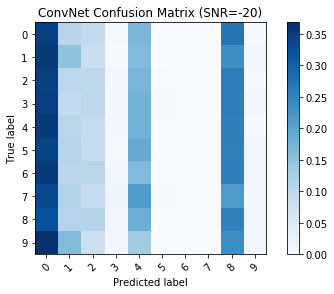

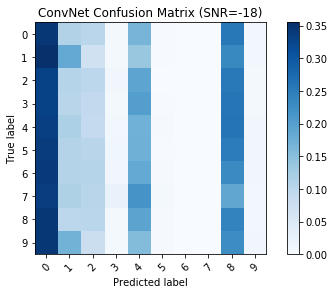

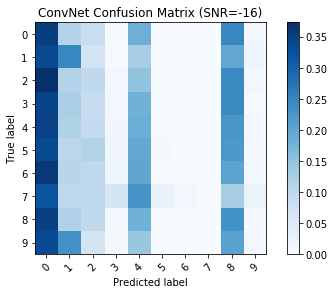

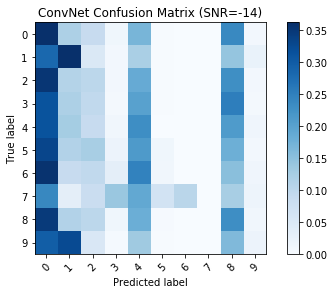

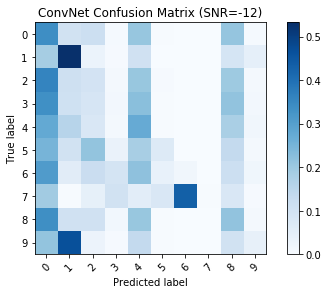

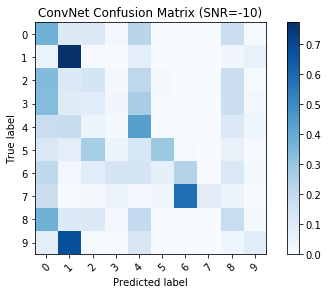

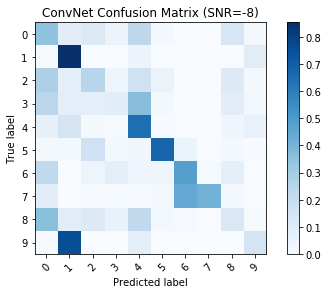

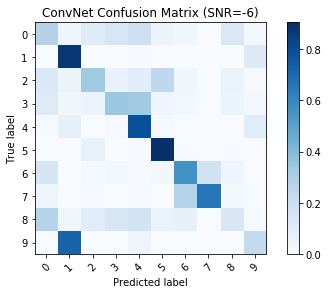

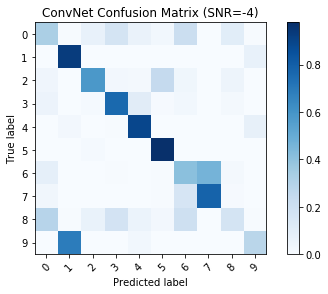

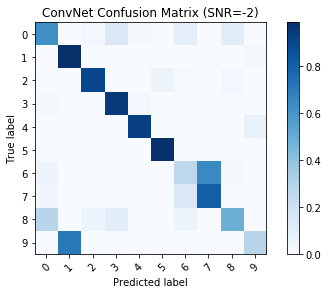

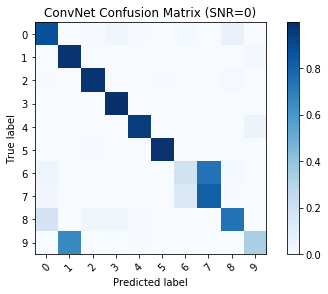

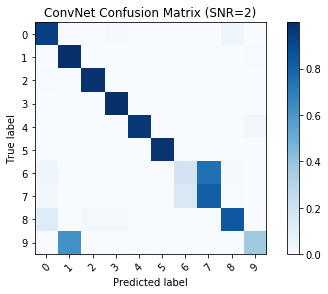

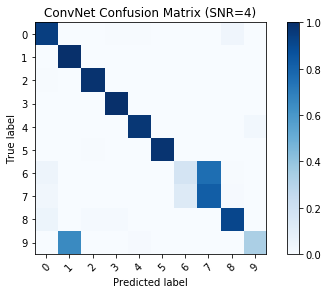

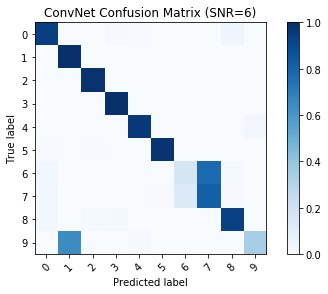

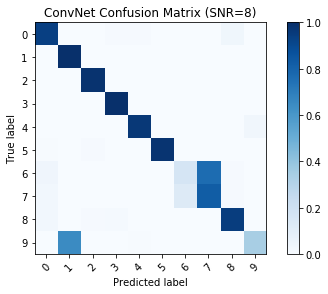

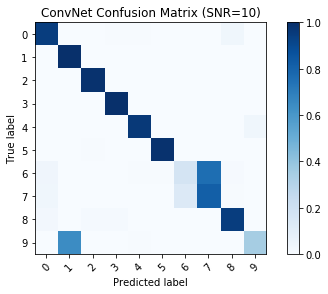

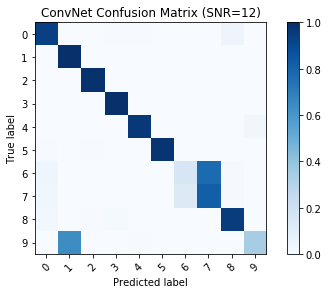

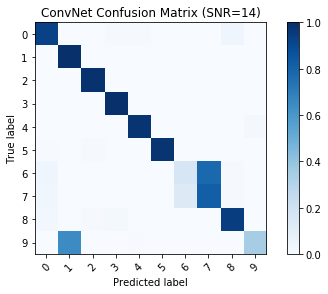

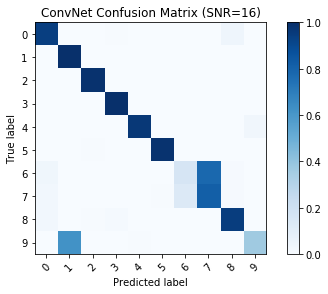

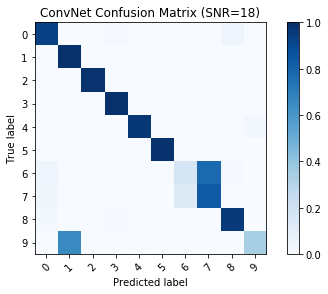

In [0]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    
    test_Y_i= np.array([np.argmax(x) for x in test_Y_i])
    #print(test_Y_i)
   
    # estimate classes
    test_X_i = (test_X_i).reshape(test_X_i.shape[0] , 2,128,1)
    test_Y_i_hat = deep_model.predict(test_X_i)
    
    
    #print(test_Y_i_hat)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = test_Y_i[i]
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("SNR: {} - Accuracy: {:.3f}%   no. of test Signals: {} ".format(snr ,100* cor / (cor+ncor),test_X_i.shape[0]))
    acc[snr] = 1.0*cor/(cor+ncor)

## Residual-LSTM  Model

In [0]:
path = "drive/My Drive/models/keras/lstm-resnet_weightsNew.h5"
# load weights into new model
lstmResnet_model.load_weights(path)
print("Loaded model from disk")
lstmResnet_model.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 2, 128, 128)       512       
_________________________________________________________________
dropout_11 (Dropout)         (None, 2, 128, 128)       0         
_________________________________________________________________
residual_4 (Residual)        (None, 2, 128, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 2, 128, 64)        49216     
_________________________________________________________________
dropout_12 (Dropout)         (None, 2, 128, 64)        0         
_________________________________________________________________
residual_5 (Residual)        (None, 2, 128, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 2, 128, 32)      

In [0]:
path = "drive/My Drive/models/keras/CLDNN-ResNetweights.h5"
cp_callback = ModelCheckpoint(path ,
                              monitor = 'val_acc',
                              save_best_only = True,
                              save_weights_only=True,
                              mode = 'max',
                              verbose=1)

#early_stop_callback = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=2, verbose=0, mode='max')


In [0]:
his = []

In [0]:
lstmResnet_model.summary()
history = lstmResnet_model.fit(x=train_X, y=train_y,
          batch_size= 1024, epochs= 20,
          verbose=2,
          callbacks = [cp_callback],
          validation_data=(val_X, val_y)
          )

his.append(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 2, 128, 128)       512       
_________________________________________________________________
dropout_11 (Dropout)         (None, 2, 128, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 2, 128, 64)        49216     
_________________________________________________________________
dropout_12 (Dropout)         (None, 2, 128, 64)        0         
_________________________________________________________________
residual_5 (Residual)        (None, 2, 128, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 2, 128, 32)        6176      
_________________________________________________________________
dropout_13 (Dropout)         (None, 2, 128, 32)        0         
__________

KeyboardInterrupt: ignored

In [0]:
his


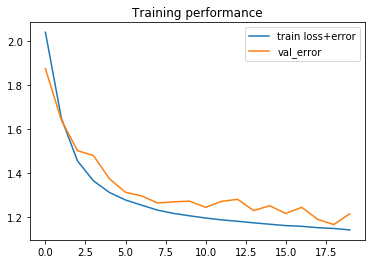

In [0]:
#history = his[0]
#history2 = his[1]
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [0]:
X_test=X_test.reshape(-1,2,128,1)
score = lstmResnet_model.evaluate(X_test, Y_test,  verbose=0, batch_size=1024)
print('Total overall score => Loss: {:.4f}   Over-All Accuracy: {:.0f}%'.format(score[0],100*score[1]))

Total overall score => Loss: 1.1289   Over-All Accuracy: 53%


### Building Model

In [0]:
from keras.engine.topology import Layer
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Add
# Define the residual block as a new layer
class Residual(Layer):
    def __init__(self, channels_in,kernel,**kwargs):
        super(Residual, self).__init__(**kwargs)
        self.channels_in = channels_in
        self.kernel = kernel

    def call(self, x):
        # the residual block using Keras functional API
        first_layer =   Activation("linear", trainable=False)(x)
        x =             Conv2D( self.channels_in,
                                self.kernel,
                                padding="same")(first_layer)
        x =             Activation("relu")(x)
        x =             Conv2D( self.channels_in,
                                self.kernel,
                                padding="same")(x)
        residual =      Add()([x, first_layer])
        x =             Activation("relu")(residual)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape
      

In [0]:


lstmResnet_model = Sequential()

lstmResnet_model.add(Conv2D(128, kernel_size=(1, 3), padding = 'same', activation= 'relu', input_shape=(2, 128, 1)))
lstmResnet_model.add(Dropout(0.5))
lstmResnet_model.add(Residual(1,(1,3)))

lstmResnet_model.add(Conv2D(64, kernel_size=(2, 3), padding = 'same', activation= 'relu'))
lstmResnet_model.add(Dropout(0.2))
#lstmResnet_model.add(Conv2D(32, kernel_size=(1, 3), padding = 'same', activation= 'relu'))

lstmResnet_model.add(Residual(64,(2,3)))

lstmResnet_model.add(Dropout(0.6))
lstmResnet_model.add(Conv2D(32, kernel_size=(1, 3), padding = 'same', activation= 'relu'))
lstmResnet_model.add(Dropout(0.6))
lstmResnet_model.add(Residual(32,(2,3)))

lstmResnet_model.add(TimeDistributed(Flatten()))

lstmResnet_model.add(LSTM(128))



lstmResnet_model.add(Dense(128, activation='relu'))
lstmResnet_model.add(Dense(128, activation='relu'))
lstmResnet_model.add(Dropout(0.6))
lstmResnet_model.add(Dense(10, activation='softmax'))

lstmResnet_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics = ['accuracy'])
lstmResnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 2, 128, 128)       512       
_________________________________________________________________
dropout_28 (Dropout)         (None, 2, 128, 128)       0         
_________________________________________________________________
residual_17 (Residual)       (None, 2, 128, 128)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 2, 128, 64)        49216     
_________________________________________________________________
dropout_29 (Dropout)         (None, 2, 128, 64)        0         
_________________________________________________________________
residual_18 (Residual)       (None, 2, 128, 64)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 2, 128, 64)        0         
__________

## Training deeper ResNet-TLSM model

In [0]:
his = []
history = lstmResnet_model.fit(x=train_X, y=train_y,
          batch_size= 1024, epochs= 150,
          verbose=2,
          callbacks = [cp_callback],
          validation_data=(val_X, val_y)
          )

his.append(history)

Train on 588000 samples, validate on 252000 samples
Epoch 1/150
 - 232s - loss: 2.0552 - acc: 0.1882 - val_loss: 1.9464 - val_acc: 0.2605

Epoch 00001: val_acc did not improve from 0.34311
Epoch 2/150
 - 229s - loss: 1.7299 - acc: 0.3156 - val_loss: 1.7364 - val_acc: 0.3308

Epoch 00002: val_acc did not improve from 0.34311
Epoch 3/150
 - 229s - loss: 1.5027 - acc: 0.3918 - val_loss: 1.8747 - val_acc: 0.3545

Epoch 00003: val_acc improved from 0.34311 to 0.35447, saving model to drive/My Drive/models/keras/CLDNN-ResNetweights.h5
Epoch 4/150
 - 229s - loss: 1.3753 - acc: 0.4361 - val_loss: 2.0544 - val_acc: 0.3400

Epoch 00004: val_acc did not improve from 0.35447
Epoch 5/150
 - 230s - loss: 1.3306 - acc: 0.4525 - val_loss: 1.8195 - val_acc: 0.3778

Epoch 00005: val_acc improved from 0.35447 to 0.37777, saving model to drive/My Drive/models/keras/CLDNN-ResNetweights.h5
Epoch 6/150


KeyboardInterrupt: ignored

In [0]:
print(__)

(252000, 2, 128, 1)


In [0]:
print(___)

In [0]:
print(_)

(360000, 2, 128)


SNR: -20 - Accuracy: 11%   no. of test Signals: 18114 
SNR: -18 - Accuracy: 11%   no. of test Signals: 17921 
SNR: -16 - Accuracy: 12%   no. of test Signals: 17933 
SNR: -14 - Accuracy: 14%   no. of test Signals: 17911 
SNR: -12 - Accuracy: 18%   no. of test Signals: 18065 
SNR: -10 - Accuracy: 27%   no. of test Signals: 18003 
SNR: -8 - Accuracy: 38%   no. of test Signals: 18086 
SNR: -6 - Accuracy: 50%   no. of test Signals: 17878 
SNR: -4 - Accuracy: 66%   no. of test Signals: 18041 
SNR: -2 - Accuracy: 80%   no. of test Signals: 17895 
SNR: 0 - Accuracy: 86%   no. of test Signals: 17964 
SNR: 2 - Accuracy: 88%   no. of test Signals: 18078 
SNR: 4 - Accuracy: 88%   no. of test Signals: 18154 
SNR: 6 - Accuracy: 88%   no. of test Signals: 17837 
SNR: 8 - Accuracy: 88%   no. of test Signals: 18010 
SNR: 10 - Accuracy: 89%   no. of test Signals: 18051 
SNR: 12 - Accuracy: 88%   no. of test Signals: 17988 
SNR: 14 - Accuracy: 88%   no. of test Signals: 18049 
SNR: 16 - Accuracy: 88%   n

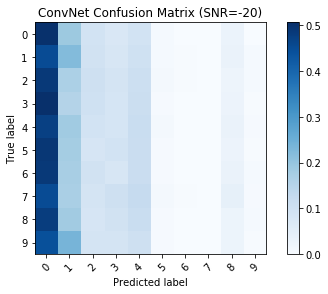

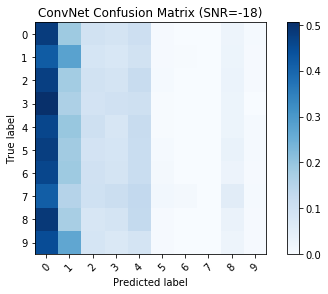

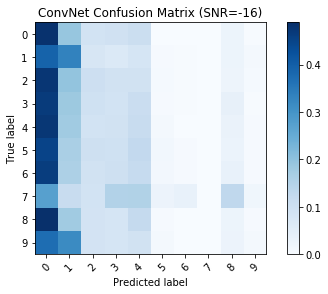

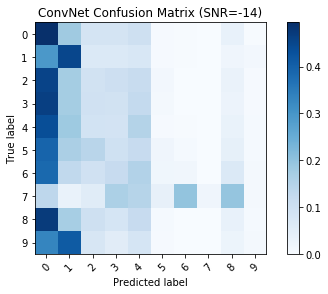

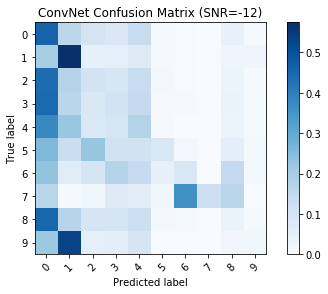

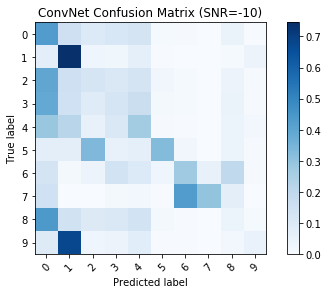

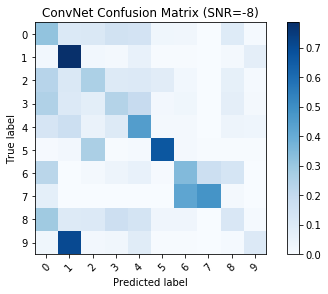

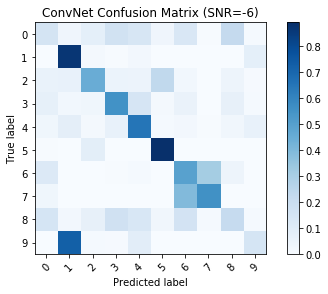

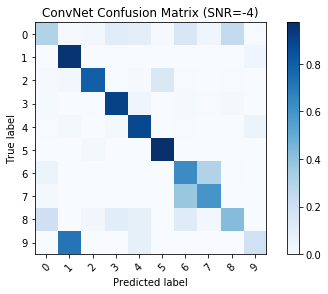

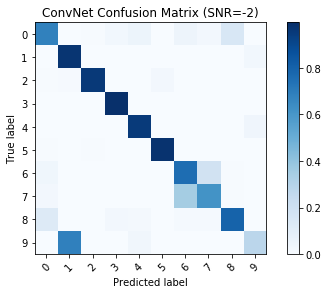

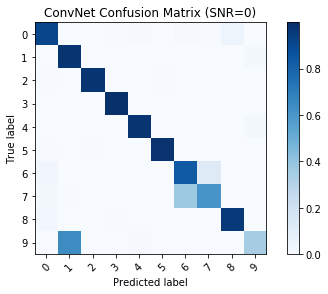

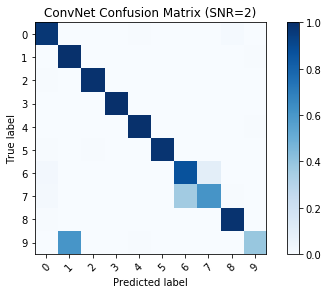

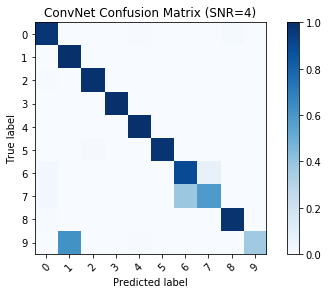

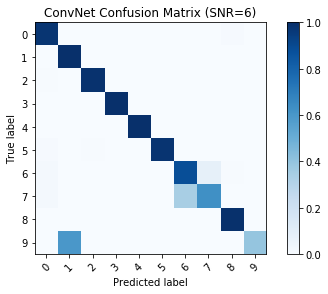

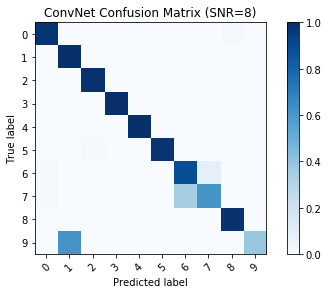

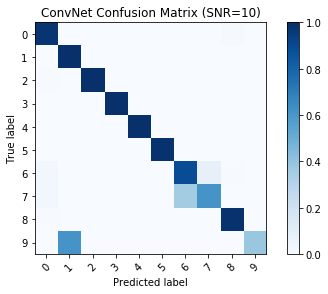

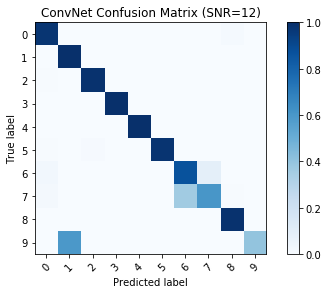

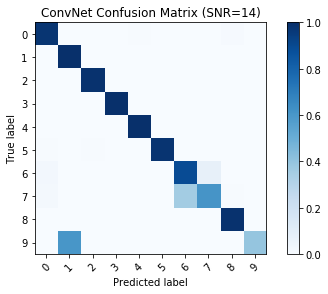

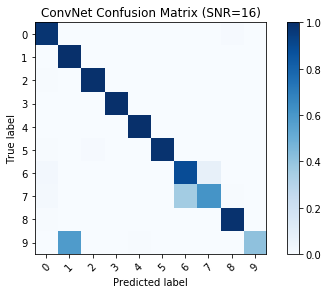

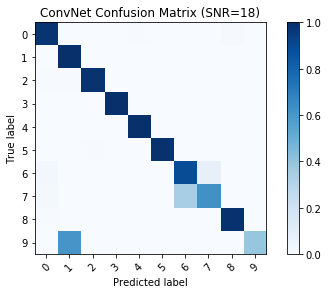

In [0]:
# Plot confusion matrix
acc = {}
classes = [0,1,2,3,4,5,6,7,8,9]
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    
    test_Y_i= np.array([np.argmax(x) for x in test_Y_i])
    #print(test_Y_i)
   
    # estimate classes
    test_X_i = (test_X_i).reshape(test_X_i.shape[0] , 2,128,1)
    test_Y_i_hat = lstmResnet_model.predict(test_X_i)
    
    
    #print(test_Y_i_hat)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = test_Y_i[i]
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("SNR: {} - Accuracy: {:.0f}%   no. of test Signals: {} ".format(snr ,100* cor / (cor+ncor),test_X_i.shape[0]))
    acc[snr] = 1.0*cor/(cor+ncor)

### Save the Model

SNR: -20 - Accuracy: 10%   no. of test Signals: 18114 


KeyboardInterrupt: ignored

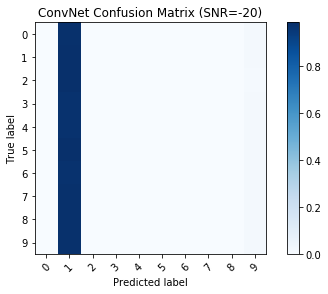

In [0]:
# Plot confusion matrix
acc = {}
classes = [0,1,2,3,4,5,6,7,8,9]
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    
    test_Y_i= np.array([np.argmax(x) for x in test_Y_i])
    #print(test_Y_i)
   
    # estimate classes
    test_X_i = (test_X_i).reshape(test_X_i.shape[0] , 2,128,1)
    test_Y_i_hat = lstmResnet_model.predict(test_X_i)
    
    
    #print(test_Y_i_hat)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = test_Y_i[i]
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("SNR: {} - Accuracy: {:.0f}%   no. of test Signals: {} ".format(snr ,100* cor / (cor+ncor),test_X_i.shape[0]))
    acc[snr] = 1.0*cor/(cor+ncor)

In [0]:
import os
path = 'drive/My Drive/models/keras/CLDNN-ResNet'
def save_model(lstm_model, path, arch = True, weights = False):
  # serialize model to JSON
  model_json = model.to_json()
  with open(os.path.join(path, 'arch.json'), "w") as json_file:
    json_file.write(model_json)
    print("model json are saved")
    # serialize weights to HDF5
lstmResnet_model.save_weights(os.path.join(path, 'weights.h5'))
print("model Weights are saved")

model Weights are saved
